In [142]:
import argparse
import os
import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import jax
from jax import vmap
import jax.numpy as jnp
import jax.random as random

import numpyro
import numpyro.distributions as dist
from numpyro.infer import (
    MCMC,
    NUTS,
    init_to_feasible,
    init_to_median,
    init_to_sample,
    init_to_uniform,
    init_to_value,
    Predictive,
)

In [44]:
%matplotlib inline

In [45]:
# squared exponential kernel with diagonal noise term
def kernel(X, Z, var, length, noise, jitter=1.0e-6, include_noise=True):
    deltaXsq = jnp.power((X[:, None] - Z) / length, 2.0)
    k = var * jnp.exp(-0.5 * deltaXsq)
    if include_noise:
        k += (noise + jitter) * jnp.eye(X.shape[0])
    return k

In [193]:
def model(X, Y=None):
    # set uninformative log-normal priors on our three kernel hyperparameters
    var = numpyro.sample("kernel_var", dist.LogNormal(0.0, 10.0))
    noise = numpyro.sample("kernel_noise", dist.LogNormal(0.0, 10.0))
    length = numpyro.sample("kernel_length", dist.LogNormal(0.0, 10.0))

    # compute kernel
    k = kernel(X, X, var, length, noise)
    L = jnp.linalg.cholesky(k)
    
    y = numpyro.sample("y", dist.TransformedDistribution(dist.Normal(0.0, jnp.ones(X.shape[0])), 
                                                         [dist.transforms.LowerCholeskyAffine(jnp.zeros(X.shape[0]), L)]
                                                        ),
                      )

    # sample Y according to the standard gaussian process formula
    # return y
    return numpyro.sample(
        "Y",
        dist.MultivariateNormal(loc=y, covariance_matrix=k),
        obs=Y,
    )

In [194]:
# do GP prediction for a given set of hyperparameters. this makes use of the well-known
# formula for gaussian process predictions
def predict(rng_key, X, Y, X_test, var, length, noise):
    # compute kernels between train and test data, etc.
    k_pp = kernel(X_test, X_test, var, length, noise, include_noise=True)
    k_pX = kernel(X_test, X, var, length, noise, include_noise=False)
    k_XX = kernel(X, X, var, length, noise, include_noise=True)
    K_xx_inv = jnp.linalg.inv(k_XX)
    K = k_pp - jnp.matmul(k_pX, jnp.matmul(K_xx_inv, jnp.transpose(k_pX)))
    sigma_noise = jnp.sqrt(jnp.clip(jnp.diag(K), a_min=0.0)) * jax.random.normal(
        rng_key, X_test.shape[:1]
    )
    mean = jnp.matmul(k_pX, jnp.matmul(K_xx_inv, Y))
    # we return both the mean function and a sample from the posterior predictive for the
    # given set of hyperparameters
    return mean, mean + sigma_noise

In [195]:
# create artificial regression dataset
def get_data(N=30, sigma_obs=0.15, N_test=400):
    np.random.seed(0)
    X = jnp.linspace(-1, 1, N)
    Y = X + 0.2 * jnp.power(X, 3.0) + 0.5 * jnp.power(0.5 + X, 2.0) * jnp.sin(4.0 * X)
    Y += sigma_obs * np.random.randn(N)
    Y -= jnp.mean(Y)
    Y /= jnp.std(Y)

    assert X.shape == (N,)
    assert Y.shape == (N,)

    X_test = jnp.linspace(-1.3, 1.3, N_test)

    return X, Y, X_test

In [196]:
args = {'x': 2}

In [197]:
num_data = 30
num_samples = 1000
num_warmup = 500
num_chains = 1
thinning = 1
device = 'cpu'
init_strategy = 'value'#'feasible'#'median'

In [198]:
X, Y, X_test = get_data(N=num_data)

# do inference
rng_key, rng_key_predict = random.split(random.PRNGKey(0))

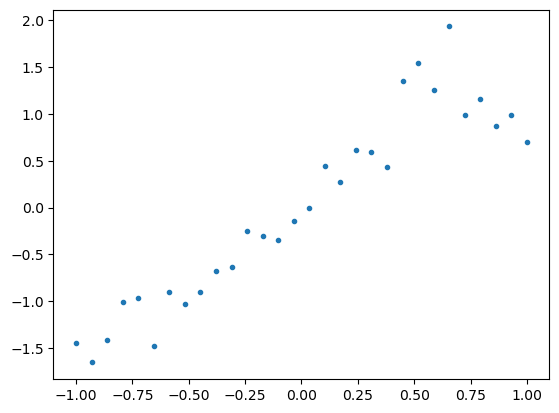

In [199]:
plt.plot(X, Y, '.')

In [200]:
pred = Predictive(model, num_samples=100)
prior_pred = pred(random.PRNGKey(2), X=X, Y=None)

In [201]:
prior_pred['y'].shape

(100, 30)

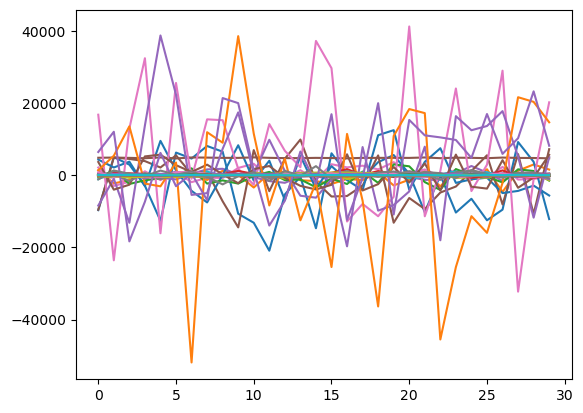

In [202]:
plt.plot(prior_pred['y'].T);

In [203]:
start = time.time()
# demonstrate how to use different HMC initialization strategies
if init_strategy == "value":
    init_strategy = init_to_value(
        values={"kernel_var": 1.0, "kernel_noise": 0.05, "kernel_length": 0.5, "y": Y}
    )
elif init_strategy == "median":
    init_strategy = init_to_median(num_samples=10)
elif init_strategy == "feasible":
    init_strategy = init_to_feasible()
elif init_strategy == "sample":
    init_strategy = init_to_sample()
elif init_strategy == "uniform":
    init_strategy = init_to_uniform(radius=1)
    
nuts_kernel = NUTS(model, init_strategy=init_strategy)

mcmc = MCMC(
    nuts_kernel,
    num_warmup=num_warmup,
    num_samples=num_samples,
    num_chains=num_chains,
    thinning=thinning,
    progress_bar=True,
)

mcmc.run(rng_key, X, Y)

mcmc.print_summary()

print("\nMCMC elapsed time:", time.time() - start)

samples = mcmc.get_samples()

sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:04<00:00, 300.63it/s, 7 steps of size 1.04e-01. acc. prob=0.89]



                     mean       std    median      5.0%     95.0%     n_eff     r_hat
  kernel_length      0.71      0.39      0.61      0.23      1.18     35.72      1.04
   kernel_noise      0.04      0.01      0.03      0.02      0.05    111.25      1.01
     kernel_var      8.50     36.51      0.84      0.08     13.43     38.63      1.04
           y[0]     -0.83      2.02     -0.72     -4.25      1.77     51.70      1.03
           y[1]     -0.92      2.08     -0.85     -4.35      1.91     50.95      1.03
           y[2]     -0.79      2.14     -0.71     -4.31      1.89     51.19      1.02
           y[3]     -0.56      2.20     -0.47     -4.24      2.18     50.87      1.02
           y[4]     -0.52      2.26     -0.44     -4.21      2.14     50.73      1.02
           y[5]     -0.77      2.33     -0.67     -4.59      1.83     50.57      1.02
           y[6]     -0.46      2.39     -0.35     -4.39      2.01     50.35      1.01
           y[7]     -0.52      2.46     -0.42     -4.

In [204]:
# do prediction
vmap_args = (
    random.split(rng_key_predict, samples["kernel_var"].shape[0]),
    samples["kernel_var"],
    samples["kernel_length"],
    samples["kernel_noise"],
)

In [205]:
means, predictions = vmap(
    lambda rng_key, var, length, noise: predict(
        rng_key, X, Y, X_test, var, length, noise
    )
)(*vmap_args)

In [206]:
samples['kernel_length'].mean()

Array(0.71472245, dtype=float32)

In [207]:
mean_prediction = np.mean(means, axis=0)
percentiles = np.percentile(predictions, [5.0, 95.0], axis=0)

[Text(0.5, 0, 'X'),
 Text(0, 0.5, 'Y'),
 Text(0.5, 1.0, 'Mean predictions with 90% CI')]

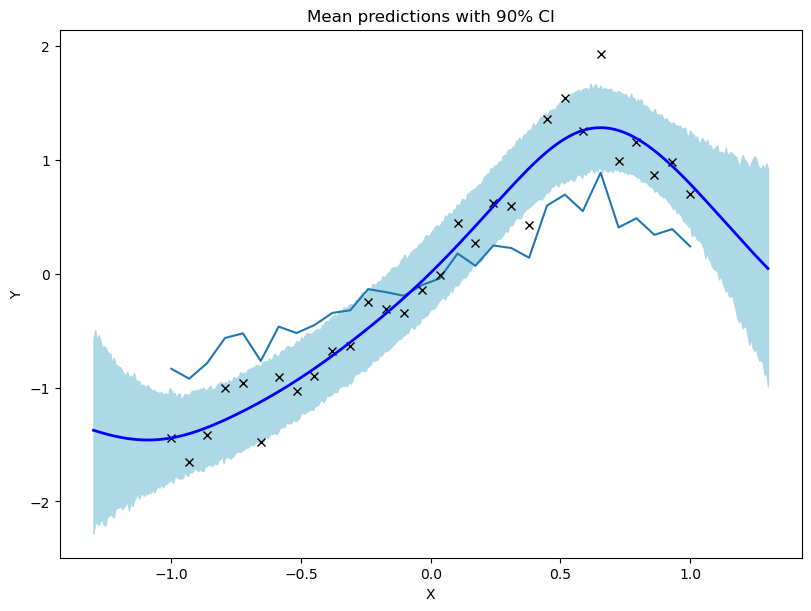

In [210]:
# make plots
fig, ax = plt.subplots(figsize=(8, 6), constrained_layout=True)

# plot training data
ax.plot(X, samples['y'].mean(axis=0))
ax.plot(X, Y, "kx")
# plot 90% confidence level of predictions
ax.fill_between(X_test, percentiles[0, :], percentiles[1, :], color="lightblue")
# plot mean prediction
ax.plot(X_test, mean_prediction, "blue", ls="solid", lw=2.0)
ax.set(xlabel="X", ylabel="Y", title="Mean predictions with 90% CI")

# plt.savefig("gp_plot.pdf")

In [ ]:
if __name__ == "__main__":
    assert numpyro.__version__.startswith("0.12.1")
    parser = argparse.ArgumentParser(description="Gaussian Process example")
    parser.add_argument("-n", "--num-samples", nargs="?", default=1000, type=int)
    parser.add_argument("--num-warmup", nargs="?", default=1000, type=int)
    parser.add_argument("--num-chains", nargs="?", default=1, type=int)
    parser.add_argument("--thinning", nargs="?", default=2, type=int)
    parser.add_argument("--num-data", nargs="?", default=25, type=int)
    parser.add_argument("--device", default="cpu", type=str, help='use "cpu" or "gpu".')
    parser.add_argument(
        "--init-strategy",
        default="median",
        type=str,
        choices=["median", "feasible", "value", "uniform", "sample"],
    )
    args = parser.parse_args()

    numpyro.set_platform(device)
    numpyro.set_host_device_count(num_chains)

    main(args)